# Plankton


In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math

from PIL import Image
from tensorflow.keras import layers, models, preprocessing
from sklearn.model_selection import train_test_split

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Link naar waar ik code hieronder vandaan heb
https://drive.google.com/file/d/1hAaPzDMVEZ8X1tfRS2ieFEqi0R7Ww7uL/view

https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder

# Loading the training data, training labels and test data

In [2]:
# Create an empty list for the test data
test_data = []

# Path to folder for the test data
folder_test = 'data/test'

# Loop through the images, read them in and add them to a list
for image in os.listdir(folder_test):
    img = cv2.imread(os.path.join(folder_test, image))
    test_data.append(img)

In [3]:
# Create empty lists for the not resized training data and then non one hot matrix labels
train_data_not_resized = []
train_labels_not_categorical = []

# Create a folder path of the different categories
folder_train = 'data/train'

# Loop through the index (for the one hot matrix) and the categories
for number, categories in enumerate(os.listdir(folder_train)):
    
    # Loop through the images , read them in and add them to a list, also add the index 'number' to 
    # a list for the one hot matrix
    for image in os.listdir(f'data/train/{categories}'):
        train_labels_not_categorical.append(number)
        img = cv2.imread(os.path.join(f'data/train/{categories}', image))
        train_data_not_resized.append(img)

# Create a one hot matrix from the train labels
train_labels = tf.keras.utils.to_categorical(train_labels_not_categorical)

# Resize input images

In [4]:
# Start with an infinitely large number
value = math.inf

# This checks for the lowest image size in the first and second dimension
# Both come out at the exact same shape, so this must me the smallest shape
for image in train_data_not_resized:
    if image.shape[0] < value:
        hold_1 = image.shape
    if image.shape[1] < value:
        hold_2 = image.shape
    
    
print(hold_1)
print(hold_2)

(33, 43, 3)
(33, 43, 3)


(33, 43, 3)


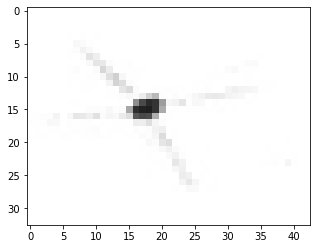

In [5]:
# Create an empty list for the training data
train_data = []

# Loop through the images in the training data and resize them to the lowest shape in the dataset, 
# then append the image to the 'train_data' list
for image in train_data_not_resized:
    img = cv2.resize(image, (43, 33))
    train_data.append(img)

# Test if the image is resized and show the image
print(train_data[0].shape)
plt.imshow(train_data[0])

#Split the data into 70% training and 30% validation
image_train, image_val, label_train, label_val = train_test_split(train_data, train_labels, train_size=0.7, random_state=1265599650)

In [7]:
# Convert the data to numpy arrays, so tensorflow can use them
image_train = np.array(image_train)
label_train = np.array(label_train)
image_val = np.array(image_val)
label_val = np.array(label_val)

# Test if the shapes are correct
print(image_train.shape)
print(label_train.shape)
print(image_val.shape)
print(label_val.shape)

ERROR! Session/line number was not unique in database. History logging moved to new session 557
(21235, 33, 43, 3)
(21235, 121)
(9101, 33, 43, 3)
(9101, 121)


# Convolutional network

In [8]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 664 steps, validate for 285 steps
Epoch 1/10
664/664 [==============================] - 9s 14ms/step - loss: 3.8824 - accuracy: 0.2904 - val_loss: 2.4571 - val_accuracy: 0.3894
Epoch 2/10
664/664 [==============================] - 2s 3ms/step - loss: 2.1691 - accuracy: 0.4350 - val_loss: 2.2341 - val_accuracy: 0.4285
Epoch 3/10
664/664 [==============================] - 2s 3ms/step - loss: 1.8334 - accuracy: 0.4946 - val_loss: 2.0247 - val_accuracy: 0.4782
Epoch 4/10
664/664 [==============================] - 2s 3ms/step - loss: 1.6106 - accuracy: 0.5448 - val_loss: 1.9887 - val_accuracy: 0.4761
Epoch 5/10
664/664 [==============================] - 2s 3ms/step - loss: 1.4304 - accuracy: 0.5833 - val_loss: 2.0111 - val_accuracy: 0.4968
Epoch 6/10
664/664 [==============================] - 2s 3ms/step - loss: 1.2953 - accuracy: 0.6176 - val_loss: 2.1462 - val_accuracy: 0.4906
Epoch 7/10
664/664 [==============================] - 2s 3ms/step - loss: 1.1700 - accuracy: 0.6450 - v

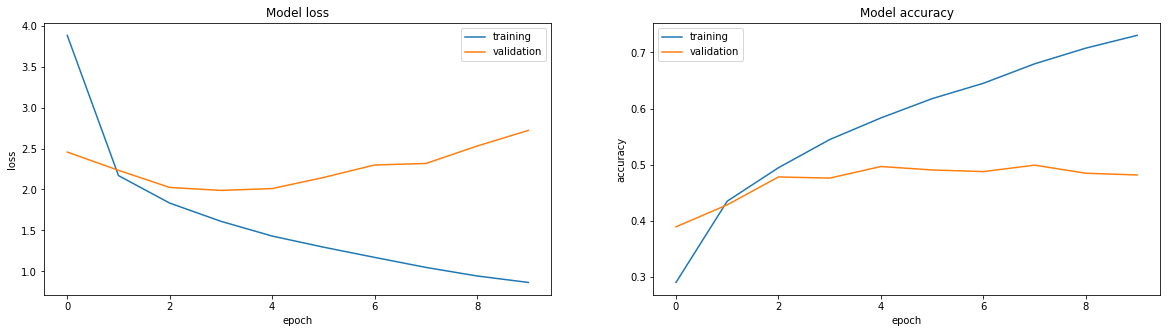

  ...
    to  
  ['...']


  ...
    to  
  ['...']


285/285 [==============================] - 0s 1ms/step - loss: 2.7208 - accuracy: 0.4817
Validation Accuracy: 0.48170530796051025


In [9]:
first_layer_filters = 32
second_layer_filters = 64
kernelsize = (3,3)
inputshape = (33,43,3)
first_hidden_layer_nodes = 128
output_nodes = 121

model_1 = models.Sequential()

model_1.add(layers.Conv2D(first_layer_filters, kernelsize, activation = 'relu', padding = 'same', input_shape = inputshape))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(second_layer_filters, kernelsize, activation = 'relu', padding = 'same', input_shape = inputshape))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(first_hidden_layer_nodes, activation = 'relu'))
model_1.add(layers.Dense(output_nodes, activation = 'softmax'))

train_and_evaluate(model_1, image_train, label_train, image_val, label_val, epochs = 10)